In [14]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pytorch_lightning as pl
import os
import numpy as np
import torch
import math
import torch.nn as nn

from torch.utils.data import DataLoader, Subset, RandomSampler, ConcatDataset
from pathlib import Path
from datetime import datetime
import torchvision.models as models

import dl_toolbox.callbacks as callbacks
import dl_toolbox.modules as modules 
import dl_toolbox.datasets as datasets
import dl_toolbox.torch_collate as collate
import dl_toolbox.utils as utils
import dl_toolbox.torch_sample as sample

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
if os.uname().nodename == 'WDTIS890Z': 
    data_root = Path('/mnt/d/pfournie/Documents/data')
    home = Path('/home/pfournie')
    save_root = data_root / 'outputs'
elif os.uname().nodename == 'qdtis056z': 
    data_root = Path('/data')
    home = Path('/d/pfournie')
    save_root = data_root / 'outputs'
else:
    #data_root = Path('/work/OT/ai4geo/DATA/DATASETS')
    data_root = Path(os.environ['TMPDIR'])
    home = Path('/home/eh/fournip')
    save_root = Path('/work/OT/ai4usr/fournip') / 'outputs'

In [17]:
# datasets params
dataset_name = 'NWPU-RESISC45'
data_path = data_root / dataset_name
nomenclature = datasets.ResiscNomenclatures['all'].value
num_classes=len(nomenclature)

test = (600, 700)
test_idx = [700*i+j for i in range(num_classes) for j in range(*test)]
test_aug = 'no'

# dataloaders params
batch_size = 16
num_workers=6

# network params
out_channels=num_classes

# module params
mixup=0. # incompatible with ignore_zero=True
class_weights = [1.] * num_classes
initial_lr=0.001
ttas=[]
alpha_ramp=utils.SigmoidRamp(2,4,0.,5.)
pseudo_threshold=0.9
consist_aug='color-5'
ema_ramp=utils.SigmoidRamp(2,4,0.9,0.99)

# trainer params
accelerator='gpu'
devices=1
ckpt_path='/data/outputs/NWPU-RESISC45/train=(0, 50)_unsup_train=(50, 100)/05Apr23-10h50m42/checkpoints/epoch=4-step=755.ckpt'

test_set = Subset(
    datasets.Resisc(
        data_path=data_path,
        img_aug=test_aug,
        nomenclature=nomenclature
    ),
    indices=test_idx
) 

test_dataloader = DataLoader(
    dataset=test_set,
    shuffle=False,
    collate_fn=collate.CustomCollate(),
    batch_size=batch_size,
    num_workers=num_workers,
)

network = models.efficientnet_b0(
    num_classes=out_channels,
)

### Building lightning module
module = modules.Supervised(
    mixup=mixup, # incompatible with ignore_zero=True
    network=network,
    #network2=network2,
    num_classes=num_classes,
    class_weights=class_weights,
    initial_lr=initial_lr,
    ttas=ttas,
    #alpha_ramp=alpha_ramp,
    #pseudo_threshold=pseudo_threshold,
    #consist_aug=consist_aug,
    #ema_ramp=ema_ramp
)

### Metrics and plots from confmat callback
metrics_from_confmat = callbacks.MetricsFromConfmat(        
    num_classes=num_classes,
    class_names=[label.name for label in nomenclature],
    plot_iou=False,
    plot_confmat=False
)

trainer = pl.Trainer(
    accelerator=accelerator,
    devices=devices,
    logger=None,
    callbacks=[
        metrics_from_confmat,
        #callbacks.MyProgressBar()
    ]
)

trainer.test(
    model=module,
    dataloaders=test_dataloader,
    #verbose=True,
    ckpt_path=ckpt_path
)
    

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Restoring states from the checkpoint path at /data/outputs/NWPU-RESISC45/train=(0, 50)_unsup_train=(50, 100)/05Apr23-10h50m42/checkpoints/epoch=4-step=755.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /data/outputs/NWPU-RESISC45/train=(0, 50)_unsup_train=(50, 100)/05Apr23-10h50m42/checkpoints/epoch=4-step=755.ckpt


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 282/282 [00:05<00:00, 51.85it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Test_loss         │    0.7691670656204224     │
│          Val_mf1          │    0.7915027194552952     │
│         Val_miou          │    0.6663687811957465     │
└───────────────────────────┴───────────────────────────┘

[{'Test_loss': 0.7691670656204224,
  'Val_miou': 0.6663687811957465,
  'Val_mf1': 0.7915027194552952}]

/tmp/ipykernel_597097/3742805668.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


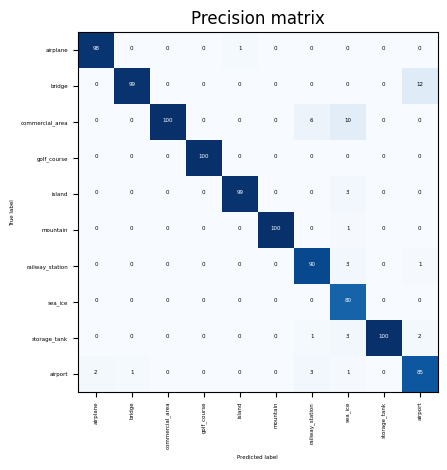

In [18]:
fig = callbacks.plot_confusion_matrix(
    metrics_from_confmat.confmat[:10,:10],
    class_names=[label.name for label in nomenclature][:10],
    norm='precision'
)
fig.show()